In [18]:
import neilpy as neil
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error as mse
from skimage.util import apply_parallel

In [2]:
# sample_dem is an extract of the NED dataset around Mt. Washington (grdn45w072_1), projected as a mercator

with rasterio.open('sample_dem.tif') as src:
    Z = src.read(1)
    Zt = src.transform

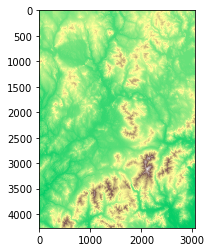

In [36]:
# Show a hysometric tint
plt.imshow(Z,cmap='terrain',vmin=-500,vmax=2000)
plt.show()

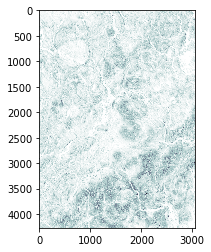

In [4]:
S = neil.slope(Z,cellsize=Zt[0],z_factor=1,return_as='degrees')
plt.imshow(S,cmap='bone_r')
plt.show()

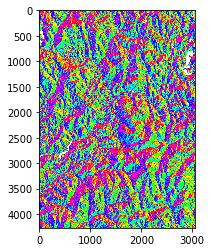

In [5]:
A = neil.aspect(Z,return_as='degrees',flat_as='nan')
plt.imshow(A,cmap='hsv')
plt.show()

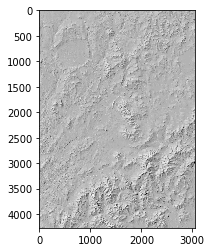

In [6]:
H = neil.hillshade(Z,cellsize=Zt[0],zenith=45,azimuth=315)
plt.imshow(H,cmap='gray',vmin=0,vmax=255)
plt.show()

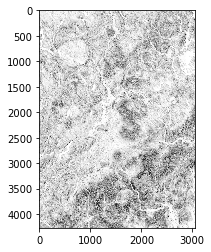

In [7]:
# Multiple Illumination will run several hillshades based on a supplied array or number of zeniths and/or azimuths:
MH = neil.multiple_illumination(Z,cellsize=Zt[0],z_factor=1,zeniths=1,azimuths=3);
plt.imshow(MH,cmap='gray_r')
plt.show()

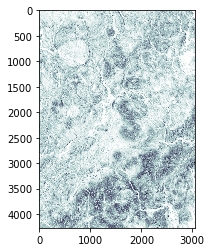

In [8]:
# The PSSM applies a vertical exaggeration to the raster.  Use reverse=True for an "x-ray" like image.
P = neil.pssm(Z,cellsize=src.transform[0],reverse=False)
plt.imshow(P)
plt.show()

In [9]:
# The z-factor can be calculated from a latitude if your raster is in degrees.  Compare to:
# https://blogs.esri.com/esri/arcgis/2007/06/12/setting-the-z-factor-parameter-correctly/

z_factor = neil.z_factor(45.323)
print(z_factor)

1.27979310076e-05


## Lidar

In [29]:
# This lidar reader is written in pure python, and uses fast numpy reading to extract the data quickly.

# DK22 is a portion of the lidar dataset for DeKalb County, in the area around Northern Illinois University.

header, df = neil.read_las('DK22_partial.las')
df.head()

,x,y,z,intensity,class,scan_angle,user_data,point_source_id,gpstime,red,green,blue,return_number,return_max,scan_direction,edge_of_flight_line
0,865089.749988,1.919702e+06,858.269973,24,1,0,0,54,398534.301993,0,0,0,1,2,False,False
1,865089.749988,1.919702e+06,858.249973,24,2,0,0,54,398534.301993,0,0,0,2,2,False,False
2,865094.839988,1.919702e+06,858.049973,23,2,0,0,54,398534.302013,0,0,0,1,2,False,False
3,865094.839988,1.919702e+06,858.319973,23,1,0,0,54,398534.302013,0,0,0,2,2,False,False
4,865098.059988,1.919701e+06,857.909973,22,2,0,0,54,398534.302033,0,0,0,1,2,False,False


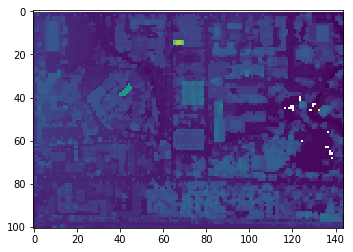

In [30]:
# Create DEM will bin the lidar data according to the specified resolution.  Use_binned_statistic will be preferable 
# once I get the bug worked out.  Empty cells will have NaNs in them.  It returns the image, as well as a rasterio-style
# affine matrix for easy reading/writting.

I,t = neil.create_dem(df.x,df.y,df.z,resolution=25,bin_type='max');
plt.imshow(I)
plt.show()

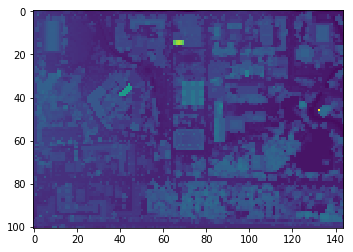

In [31]:
# Holes in DEMs can be repaired via inpainting.  These are replications of D'Errico's excellent inpaint_nans routines.
# The Finite Difference Approximation method can either be fast (using only pixels around missing values) or build the system.
# This should correspond to methods 0 (fast) and 1 (not fast) of D'Errico's methods.
J = neil.inpaint_nans_by_fda(I,inplace=False,fast=True)
plt.imshow(J)
plt.show()

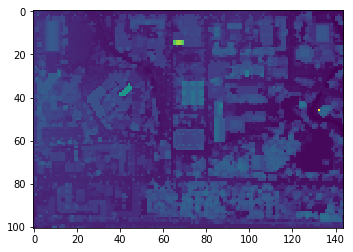

In [32]:
# The "springs" method is method 4 of D'Errico's orignal routine.
J = neil.inpaint_nans_by_springs(I,inplace=False)
plt.imshow(J)
plt.show()

The exact solution is  x = 0                              


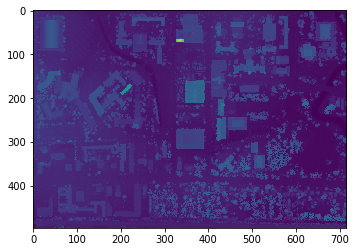

In [33]:
# DEMs with holes generated from lidar point clouds, binned at high resolution can be generated by
# breaking up the tile and solving in parallel, specifying tile size (here, 100) and overlap (here, 10 pixels):

header, df = neil.read_las('dk22_partial.las')
I,t = neil.create_dem(df.x,df.y,df.z,resolution=5,bin_type='max');
J = apply_parallel(neil.inpaint_nans_by_springs,I.copy(),100,10)
plt.imshow(J)
plt.show()